In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
import glob
import matplotlib.pyplot as plt


# Example physionet

In [6]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'C:/Users/Deivid.Smarzaro/OneDrive - Bentley Systems, Inc/TCC/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=500  # 500 Hz for high resolution, 100 for low resolution

# load and convert annotation data
Y = pd.read_csv(os.path.join(path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


# [Pre-Processing PTB-XL Signal (Scalogram)](https://www.kaggle.com/code/debbyrofikomalik/pre-processing-ptb-xl-signal-scalogram)

In [7]:
# Path file database PTB-XL
record_path = "C:/Users/Deivid.Smarzaro/OneDrive - Bentley Systems, Inc/TCC/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/00000/00001_hr"
# Load sinyal ECG
signals, fields = wfdb.rdsamp(record_path)
# Cek hasil
print("Shape signal:", signals.shape)
print("Metadata:", fields)

Shape signal: (5000, 12)
Metadata: {'fs': 500, 'sig_len': 5000, 'n_sig': 12, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'comments': []}


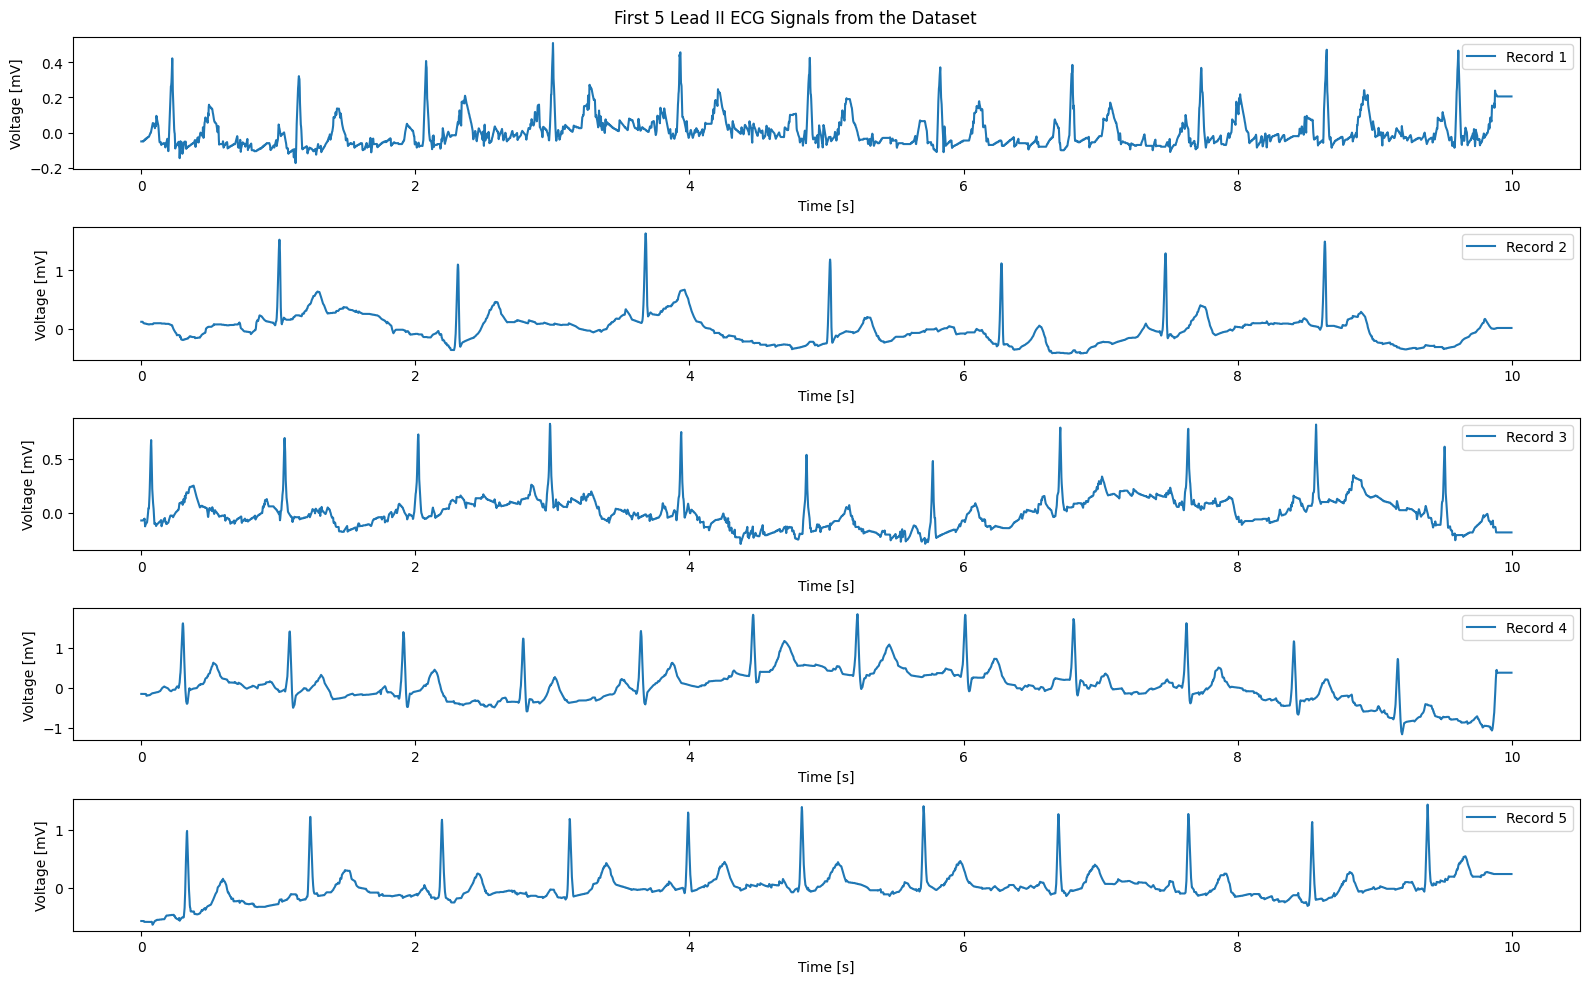

In [10]:
# Mencari 5 file pertama di records500
base_path = "C:/Users/Deivid.Smarzaro/OneDrive - Bentley Systems, Inc/TCC/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/00000/"
record_files = sorted(glob.glob(base_path + "*.dat"))[:5]  # Take the first 5 files

plt.figure(figsize=(16, 10))

for i, file_path in enumerate(record_files):
    record_name = file_path[:-4]  # Remove .dat extension to get the record name
    signals, fields = wfdb.rdsamp(record_name)

    # Take only Lead II (index 1)
    lead_II_signal = signals[:, 1]
    fs = fields['fs']  # Frekuensi sampling (500 Hz)
    time = np.arange(len(lead_II_signal)) / fs

    # Plot signal
    plt.subplot(5, 1, i + 1)
    plt.plot(time, lead_II_signal, label=f"Record {i+1}")
    plt.xlabel("Time [s]")
    plt.ylabel("Voltage [mV]")
    plt.legend()
    plt.grid(False)

plt.suptitle("First 5 Lead II ECG Signals from the Dataset")
plt.tight_layout()
plt.show()

In [9]:
base_path = "C:/Users/Deivid.Smarzaro/OneDrive - Bentley Systems, Inc/TCC/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
df = pd.read_csv(base_path + "ptbxl_database.csv")  # Main ECG data

# Display the first few rows of the PTB-XL Database
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [ ]:
# Load dataset SCP Statements
agg_df = pd.read_csv("C:/Users/Deivid.Smarzaro/OneDrive - Bentley Systems, Inc/TCC/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv", index_col=0)

# Display the first few rows of SCP Statements

agg_df.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


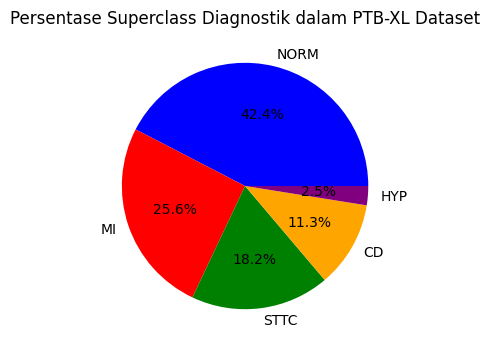

In [12]:
# Konversi string scp_codes ke dictionary
df["scp_codes_dict"] = df["scp_codes"].apply(lambda x: ast.literal_eval(x))

# Ambil hanya kategori diagnostik dari SCP Statements
agg_df = agg_df[agg_df["diagnostic"] == 1]

# Fungsi untuk mengelompokkan superclass diagnostik
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

df["diagnostic_superclass"] = df["scp_codes_dict"].apply(aggregate_diagnostic)

# Tetapkan satu superclass per rekaman berdasarkan prioritas
prioritas = ["MI", "STTC", "CD", "HYP", "NORM"]

def pilih_superclass(superclass_list):
    for kelas in prioritas:
        if kelas in superclass_list:
            return kelas
    return None  # Kalau kosong

df["final_superclass"] = df["diagnostic_superclass"].apply(pilih_superclass)

# Hitung distribusi kelas setelah pemrosesan
class_counts = df["final_superclass"].value_counts()

# Visualisasi dengan pie chart (dengan ukuran lebih kecil)
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=["blue", "red", "green", "orange", "purple"])
plt.title("Persentase Superclass Diagnostik dalam PTB-XL Dataset")
plt.show()

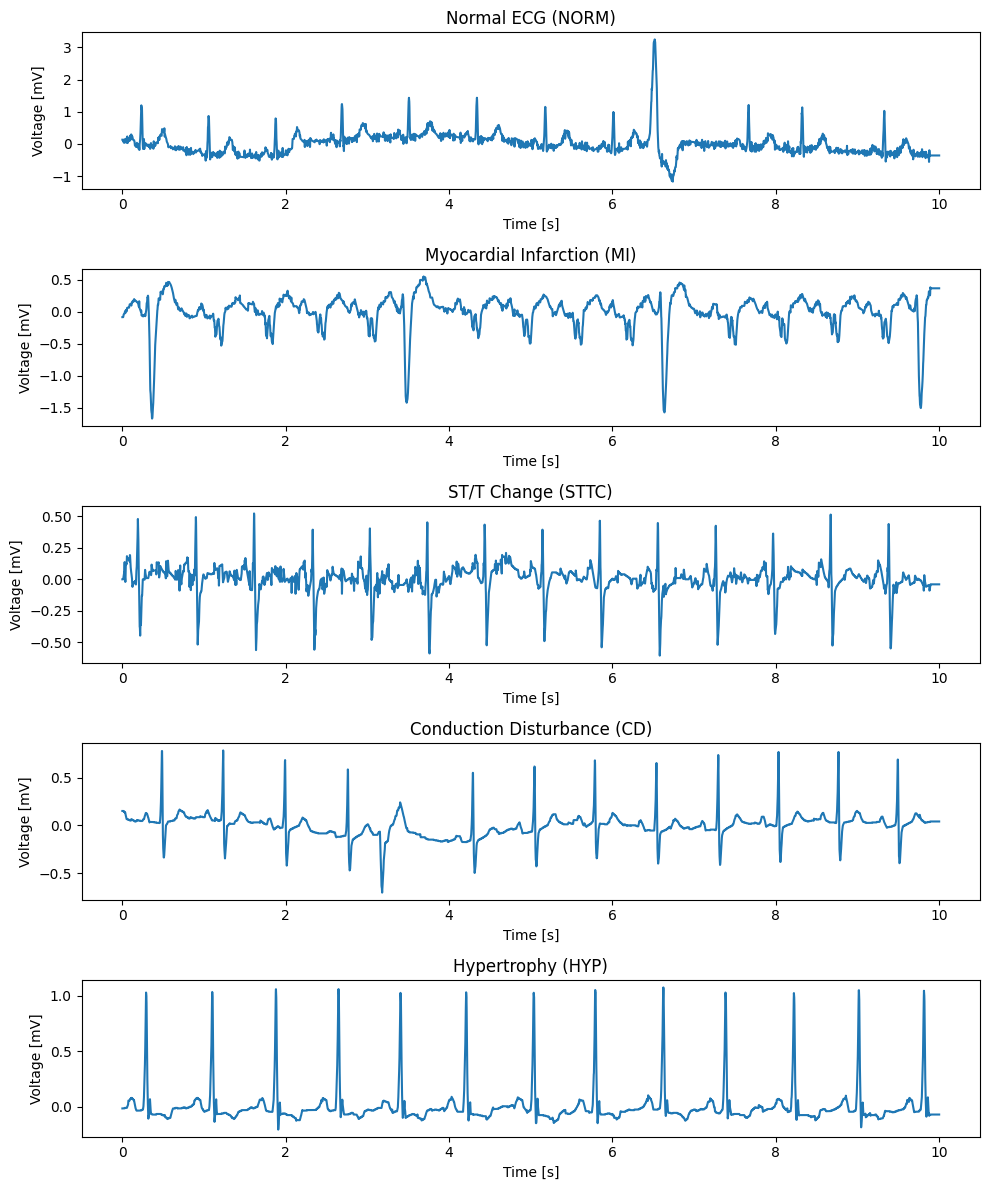

In [14]:
# Load main dataset (PTB-XL) and SCP Statements
base_path = 'C:/Users/Deivid.Smarzaro/OneDrive - Bentley Systems, Inc/TCC/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

df = pd.read_csv(base_path + "ptbxl_database.csv")  # Main ECG data
agg_df = pd.read_csv(base_path + "scp_statements.csv", index_col=0)  # SCP classification data

# Use dataset with 500 Hz sampling rate
df["file_path"] = base_path + df["filename_hr"]

# Convert string scp_codes to dictionary
df["scp_codes_dict"] = df["scp_codes"].apply(lambda x: ast.literal_eval(x))

# Aggregate diagnostic superclass based on SCP Statements
agg_df = agg_df[agg_df["diagnostic"] == 1]  # Take only diagnostic category

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

df["diagnostic_superclass"] = df["scp_codes_dict"].apply(aggregate_diagnostic)

# Select classes to visualize
class_dict = {
    "NORM": "Normal ECG",
    "MI": "Myocardial Infarction",
    "STTC": "ST/T Change",
    "CD": "Conduction Disturbance",
    "HYP": "Hypertrophy"
}

# Take one random signal example from each class
fig, axes = plt.subplots(len(class_dict), 1, figsize=(10, 12))

for i, (class_code, class_name) in enumerate(class_dict.items()):
    # Filter dataframe by diagnostic class
    df_class = df[df["diagnostic_superclass"].apply(lambda x: class_code in x)]
    
    if not df_class.empty:
        # Select one random record
        example_record = df_class.sample(n=1).iloc[0]
        file_path = example_record["file_path"]

        # Load ECG signal data
        record = wfdb.rdsamp(file_path)
        signal = record[0][:, 1]  # Take Lead II

        # Plot ECG signal
        time = np.linspace(0, 10, len(signal))  
        axes[i].plot(time, signal)
        axes[i].set_title(f"{class_name} ({class_code})")
        axes[i].set_xlabel("Time [s]")
        axes[i].set_ylabel("Voltage [mV]")

plt.tight_layout()
plt.show()

# Processing MI only

In [19]:
# Create a df with only MI data
mi_df = df[df["scp_codes_dict"].apply(lambda x: any(code in agg_df.index and agg_df.loc[code, "diagnostic_class"] == "MI" for code in x.keys()))]
# Display the first few rows of MI data
print(mi_df.shape)
mi_df.head()

(5469, 31)


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,file_path,scp_codes_dict,diagnostic_superclass
7,8,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,...,NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
38,39,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-16 12:54:01,...,NaN,NaN,NaN,NaN,9,records100/00000/00039_lr,records500/00000/00039_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'IMI': 15.0, 'LNGQT': 100.0, 'NST_': 100.0, '...","[MI, STTC]"
49,50,16961.0,59.0,1,NaN,64.0,2.0,0.0,CS-12 E,1985-05-09 12:01:24,...,NaN,NaN,NaN,NaN,7,records100/00000/00050_lr,records500/00000/00050_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'LMI': 15.0, 'IVCD': 100.0, 'SR': 0.0}","[MI, CD]"
62,63,15265.0,30.0,0,NaN,78.0,2.0,0.0,CS-12 E,1985-07-03 09:27:10,...,NaN,NaN,NaN,NaN,10,records100/00000/00063_lr,records500/00000/00063_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'ASMI': 15.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
76,77,8555.0,43.0,0,NaN,63.0,0.0,0.0,CS-12 E,1985-09-27 09:55:22,...,NaN,NaN,NaN,NaN,6,records100/00000/00077_lr,records500/00000/00077_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'AMI': 50.0, 'IRBBB': 100.0, 'SR': 0.0}","[MI, CD]"


In [21]:
# Filter rows where diagnostic_superclass contains only ['MI']
mi_only_df = df[df["diagnostic_superclass"].apply(lambda x: x == ['MI'])]
mi_only_df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,file_path,scp_codes_dict,diagnostic_superclass
7,8,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,...,NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
62,63,15265.0,30.0,0,NaN,78.0,2.0,0.0,CS-12 E,1985-07-03 09:27:10,...,NaN,NaN,NaN,NaN,10,records100/00000/00063_lr,records500/00000/00063_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'ASMI': 15.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
130,131,13698.0,57.0,1,NaN,57.0,0.0,0.0,CS-12 E,1986-02-08 10:29:06,...,NaN,NaN,NaN,NaN,8,records100/00000/00131_lr,records500/00000/00131_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'ASMI': 50.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
145,153,20254.0,46.0,0,NaN,99.0,0.0,0.0,CS-12 E,1986-03-01 11:54:49,...,NaN,NaN,NaN,NaN,9,records100/00000/00153_lr,records500/00000/00153_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'IMI': 15.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
147,155,12640.0,68.0,0,NaN,106.0,2.0,0.0,CS-12 E,1986-03-03 10:10:17,...,NaN,NaN,NaN,NaN,9,records100/00000/00155_lr,records500/00000/00155_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'ILMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21760,21799,12488.0,66.0,1,NaN,NaN,0.0,0.0,CS100 3,2001-02-03 10:57:15,...,NaN,NaN,NaN,NaN,1,records100/21000/21799_lr,records500/21000/21799_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'IMI': 50.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
21772,21811,12934.0,75.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-02-19 16:33:28,...,NaN,NaN,NaN,NaN,7,records100/21000/21811_lr,records500/21000/21811_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'IMI': 50.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
21781,21820,18655.0,80.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-03-03 17:34:11,...,NaN,NaN,NaN,NaN,7,records100/21000/21820_lr,records500/21000/21820_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'IMI': 15.0, 'SR': 0.0}",[MI]
21785,21824,19977.0,69.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-05-10 08:10:23,...,NaN,NaN,NaN,NaN,8,records100/21000/21824_lr,records500/21000/21824_hr,C:/Users/Deivid.Smarzaro/OneDrive - Bentley Sy...,"{'AMI': 15.0, 'ABQRS': 0.0, 'SR': 0.0}",[MI]
